In [1]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz,pickle, yaml
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr, concat, drone, bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site
import beamcals.reduce_ccclass as rc
gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

#Epols = [0,3,4,7,9,10,12,14]
#Npols = [1,2,5,6,8,11,13,15]

Epols = [0,2,4,6,8,10,12,14]
Npols = [1,3,5,7,9,11,13,15]
config_directory="/hirax/GBO_Analysis_Outputs/concat_config_files/"

# dishes are 2n, 2n+1 pairs

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

In [2]:
# Read the yaml for the flight you're interested in:
fly = '608'
cdat = '20211020T215858Z'

if int(fly) < 537:
    mdir='/hirax/GBO_Aug_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # August 2021
    gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # August 2021
else:
    mdir='/hirax/GBO_Oct_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # Oct 2021
    gaindir='/hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # Oct 2021

sdir = os.listdir(mdir)[0]
datadir=mdir+sdir+'/'
print(sdir, datadir,gaindir)
    
dronedir='/hirax/all_drone_data/datcon_csv/'
dronetest0825=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite,tlb=0,tub=-1)

print('DONE reading in drone data')
print(dronetest0825.t_arr_datetime[0], dronetest0825.t_arr_datetime[-1])

20211020T215911Z /hirax/GBO_Oct_2021/TONE_ACQ/20211020T215858Z_yale_drone/corr/20211020T215911Z/ /hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/20211020T215858Z_yale_drone_yale_digitalgain/
Initializing drone data via datcon_csv routine: FLY608.csv
  --> Skipping rows 1 to 499 to eliminate NAN values
  --> Attempting to load position data from RTK
    --> RTK Data not found for this data file...
  --> Loading position data from GPS(0) instead:
Timestamp interpolation succeeded
  --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
  --> generating dish and receiver line of sight coordinates.
DONE reading in drone data
2021-10-20 22:01:03.800000+00:00 2021-10-20 22:12:56.996000+00:00


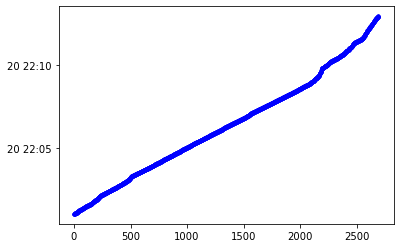

plotting drone coordinates for all time samples:
overplotting drone coordinates for t_cut samples: [0:-1]


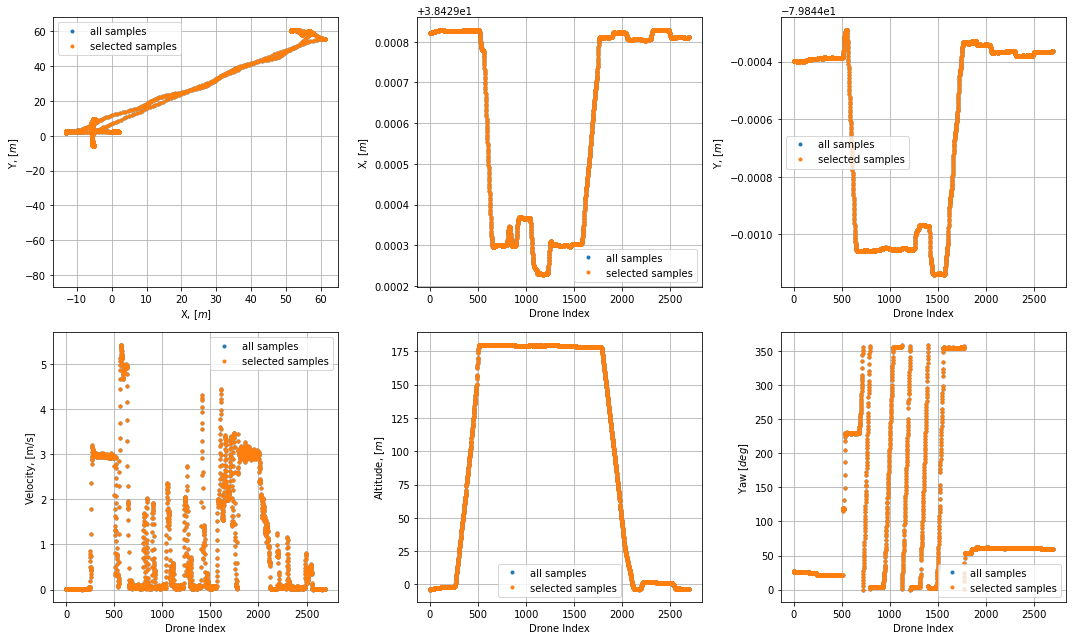

In [3]:
plt.plot(dronetest0825.t_arr_datetime,'b.',label='drone')
plt.show()

pu.Plot_Drone_Coordinates(dronetest0825,coo='xy')#,t_bounds=[tlb,tub])
#pu.Plot_Drone_Coordinates(dronetest0825,coo='xy',t_bounds=[tlb,tub])


start time:  2023-12-07 20:47:21.216176
Initializing Correlator Class using:
  --> /hirax/GBO_Oct_2021/TONE_ACQ/20211020T215858Z_yale_drone/corr/20211020T215911Z/
  --> Arrays initialized with shape (60, 256, 1024, 16)
Assigning array values by reading in data files:
  --> Loading File: 0059/0059
  --> Finished. Reshaping arrays.
end time:  2023-12-07 20:51:01.094323


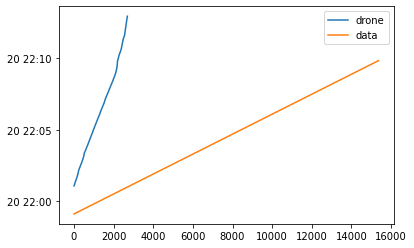

In [4]:
## Combine drone and correlator data
print('start time: ', datetime.datetime.now())
corrtest0825=corr.Corr_Data(Data_Directory=datadir,
                            Gain_Directory=gaindir,site_class=gbosite,
                            crossmap=[])
#

    
print('end time: ', datetime.datetime.now())

# putting checks in one cell now that I know I've mostly figured out the flight/corr file correspondence
# This checks I copied and pasted ok :)

## plot their datetime arrays to check overlap:

plot(dronetest0825.t_arr_datetime,label='drone')
plot(corrtest0825.t_arr_datetime,label='data')
legend()


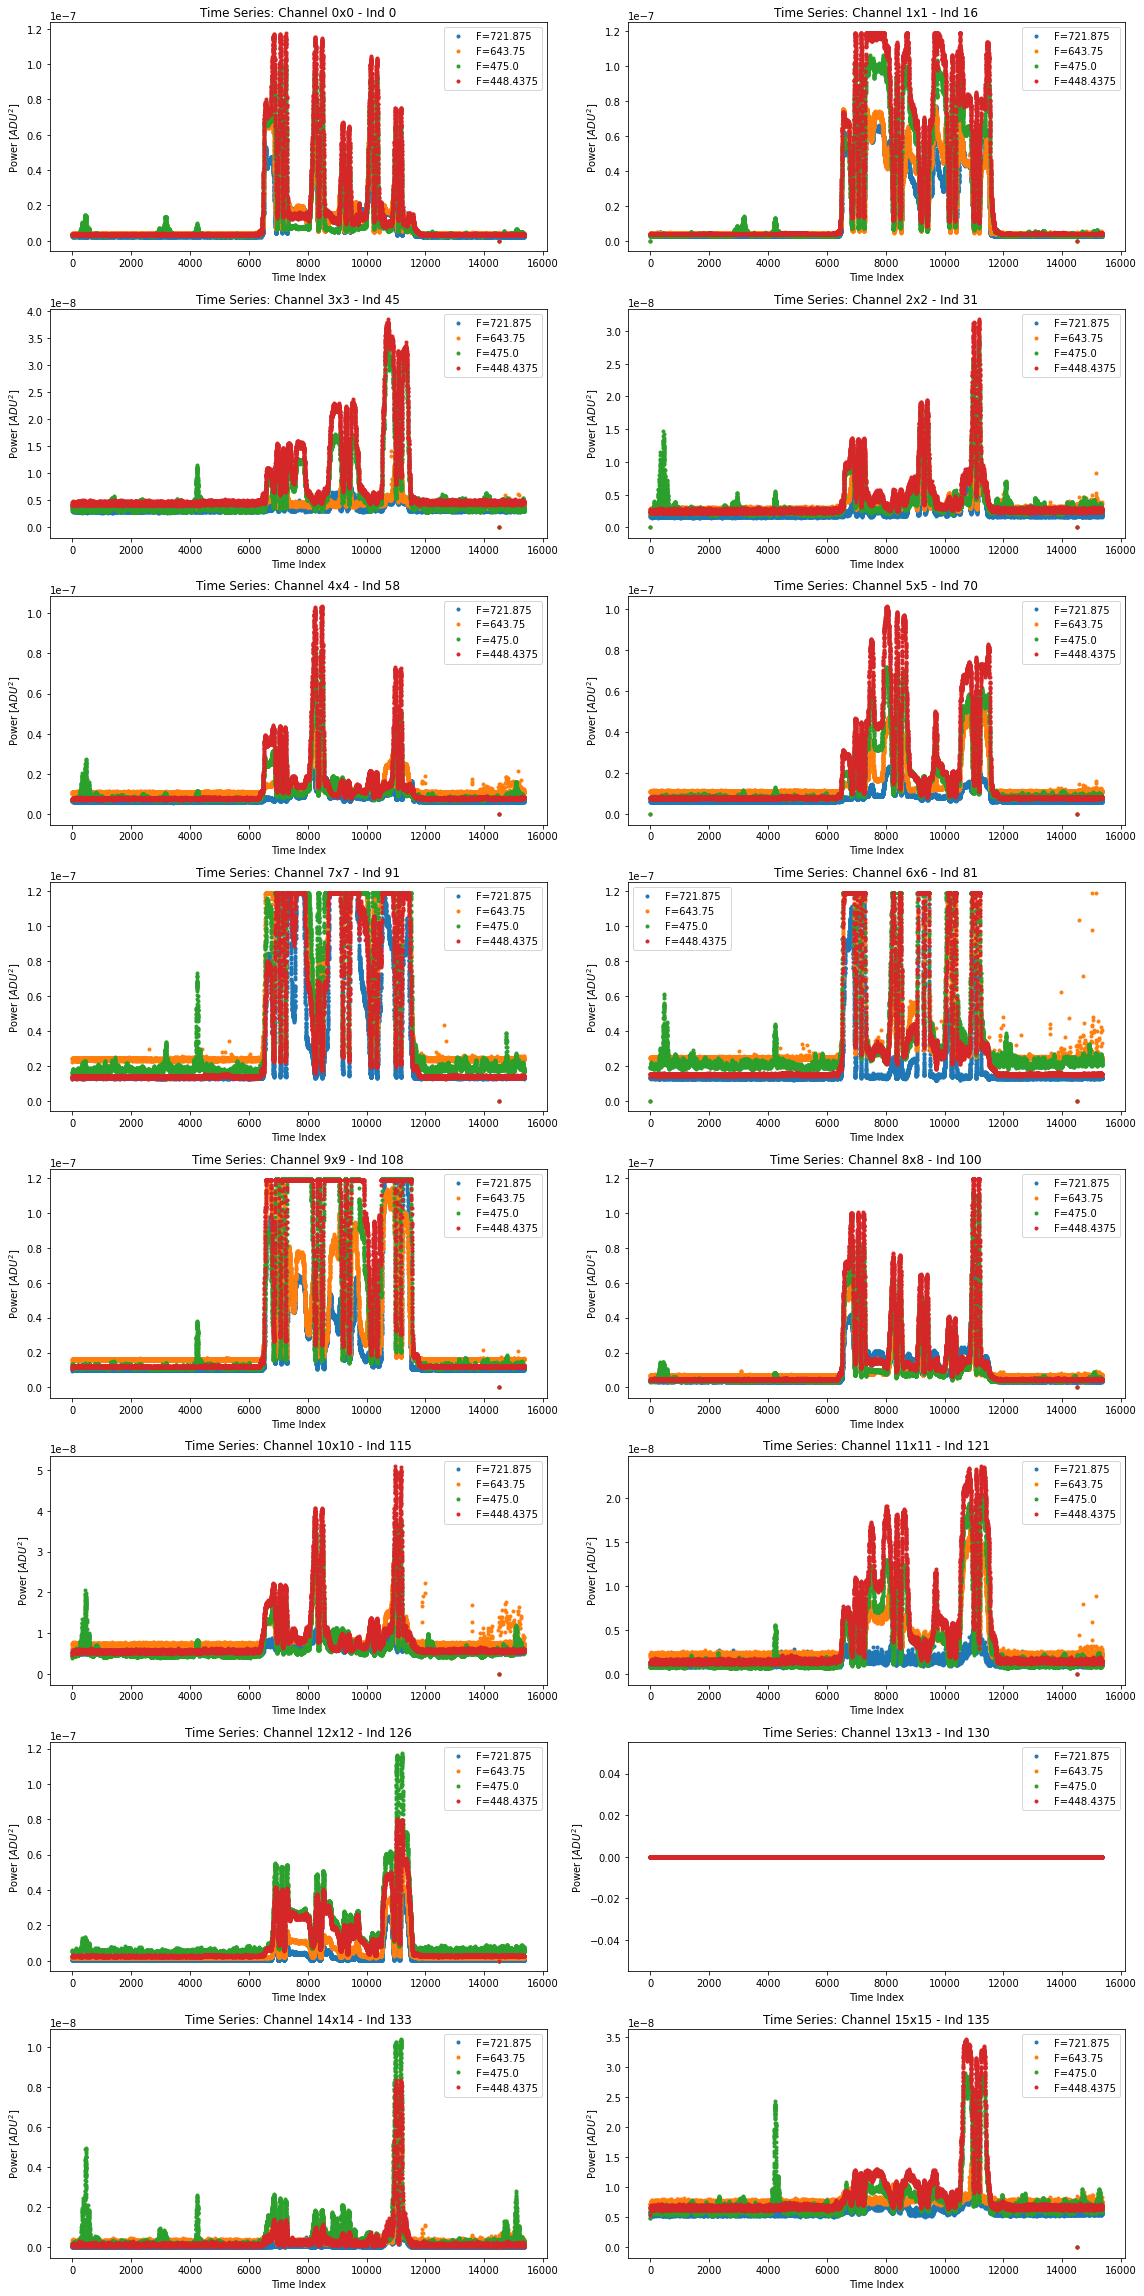

In [6]:
config_directory="/hirax/GBO_Analysis_Outputs/concat_config_files/"

concattest=concat.CONCAT(CORRDATCLASS=corrtest0825,DRONEDATCLASS=dronetest0825,\
                             load_yaml=False,traceback=False,save_traceback=False)
#concattest0825=concat.CONCAT(CORRDATCLASS=corrtest0825,DRONEDATCLASS=dronetest0825,load_yaml=True,
#                             traceback=False,save_traceback=False)

pu.Plot_Time_Series(concattest,freqlist=[200,400,832,900]) # previously set to just 700

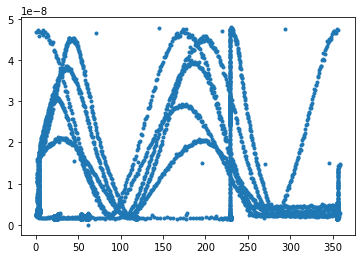

In [7]:
plt.plot(concattest.drone_yaw_interp, concattest.V[:,600,0], '.')

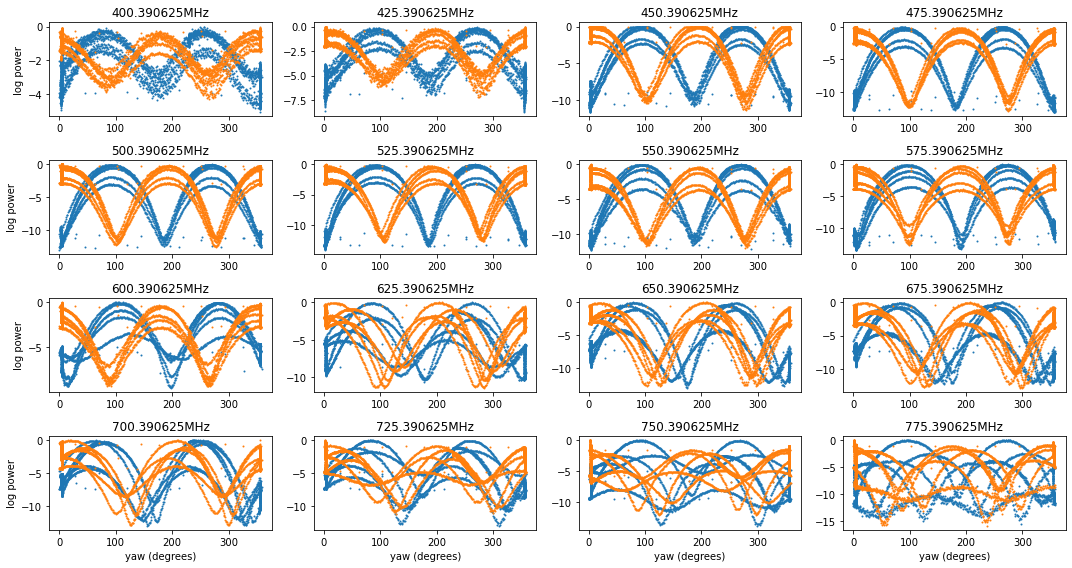

In [8]:
lb = 6600
ub = 11500
offset = 100

fig = figure(figsize = (15,8))
for i, freq in enumerate(np.arange(1023,0,-64)):
    freq1=freqs[freq]
    ax = fig.add_subplot(4,4,i+1)
    for j in np.arange(0,2,1):
        ax.plot(concattest.drone_yaw_interp[lb+offset:ub+offset], 10*np.log10(concattest.V[:,freq,j][lb:ub])\
                -np.max(10*np.log10(concattest.V[:,freq,j][lb:ub])), '.', markersize = 2)
    ax.set_title(str(freq1)+'MHz')
    if i%4 == 0: ax.set_ylabel('log power')
    if i in range(12,16): ax.set_xlabel('yaw (degrees)')
#wtf
tight_layout()
show()


In [9]:
a = concattest.drone_xyz_LC_interp

inds = [np.where((a[:,0] < 20)), np.where((a[:,1] < 20))]

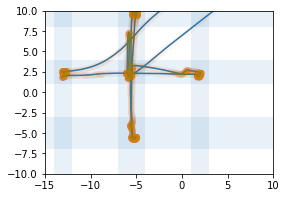

In [10]:
figure(figsize = (9,3))
subplot(1,2, 1)
plot(concattest.drone_xyz_LC_interp[:,0], concattest.drone_xyz_LC_interp[:,1])

# for i in indsx1:

axhspan(1,4, alpha = 0.1)
axhspan(8,11, alpha = 0.1)
axhspan(-7,-3, alpha = 0.1)

axvspan(-7,-4, alpha = 0.1)
axvspan(1,3, alpha = 0.1)
axvspan(-14,-12, alpha = 0.1)
ylim(-10,10)
xlim(-15,10)

plot(concattest.drone_xyz_LC_interp[:,0], concattest.drone_xyz_LC_interp[:,1], 'o', alpha = 0.01)
ylim(-10,10)
xlim(-15,10)
show()


In [12]:
indsx= [np.where((bounds_x[i][0] < a[:,0]) & (a[:,0] < bounds_x[i][1]))[0] for i in range(3)]
indsy= [np.where((bounds_y[i][0] < a[:,1]) & (a[:,1] < bounds_y[i][1]))[0] for i in range(3)]


indsx= [np.where((bounds_x[i][0] < a[:,1]) & (a[:,1] < bounds_x[i][1]))[0] for i in range(3)]
indsy= [np.where((bounds_y[i][0] < a[:,0]) & (a[:,0] < bounds_y[i][1]))[0] for i in range(3)]

len(indsx[0])+len(indsx[1])+len(indsx[2])

indsx1 = list(indsx[0])+list(indsx[1])+list(indsx[2])
indsy1 = list(indsy[0])+list(indsy[1])+list(indsy[2])


bounds_x = [(1,4),(8,11),(-7,-3)]
bounds_y = [(-7,-4),(1,3),(-14,-12)]

indsx= [np.where((bounds_x[i][0] < a[:,0]) & (a[:,0] < bounds_x[i][1]))[0] for i in range(3)]
indsy= [np.where((bounds_y[i][0] < a[:,1]) & (a[:,1] < bounds_y[i][1]))[0] for i in range(3)]


indsx= [np.where((bounds_x[i][0] < a[:,1]) & (a[:,1] < bounds_x[i][1]))[0] for i in range(3)]
indsy= [np.where((bounds_y[i][0] < a[:,0]) & (a[:,0] < bounds_y[i][1]))[0] for i in range(3)]
# [[]+indsx[i] for i in range(3)]
inds = np.intersect1d(indsx1,indsy1)

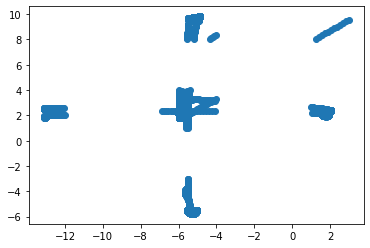

In [13]:
plot(concattest.drone_xyz_LC_interp[inds,0], concattest.drone_xyz_LC_interp[inds,1], 'o')
show()

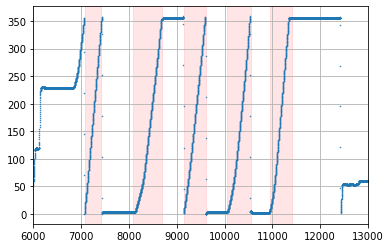

In [14]:
plot(concattest.drone_yaw_interp, '.', markersize = 1)
# # plot(test_concat.drone_xyz_LC_interp[:,2])
# plot(test_concat.drone_xyz_LC_interp[:,0])
# plot(test_concat.drone_xyz_LC_interp[:,1])

# for i in [7080, 7450,8090,8700,9150,9600,10050,10550,10950,11400]:
#     axvline(i, color = 'k')
    
    
for i in [(7080, 7420),(8090,8700),(9150,9600),(10050,10550),(10950,11400)]:
    axvspan(i[0],i[1],color = 'r', alpha = 0.1)
    
xlim(6000,13000)
grid()


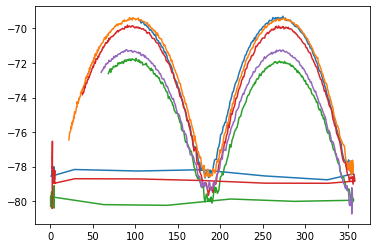

In [15]:
for i in [(7080, 7420),(8090,8700),(9150,9600),(10050,10550),(10950,11400)]:
# for i in [(10950,11400)]:
    plot(concattest.drone_yaw_interp[offset:][i[0]:i[1]], 10*np.log10(concattest.V[i[0]:i[1],900,0]))
show()

In [16]:
# def sin_fun(x,a,b,c):
#     return a*np.sin(b*x)+c

def sin_fun(x,*params):
    [a,b,c,d] = params
#     return a*np.sin(b*x*np.pi/180+c)+d    
    return a*np.sin(b*x*np.pi/180-c*np.pi/180)+d   

def sin_fun2(x,*params):
    
    [a,b,c,d] = params
#     return a*np.sin(b*x*np.pi/180+c)+d    
    return a*np.sin(b*(x-c)*np.pi/180)+d   
# 

def cos_fun(x,*params):
    
    [a,b,c,d] = params
#     return a*np.sin(b*x*np.pi/180+c)+d    
    return a*np.cos(b*(x-c)*np.pi/180)+d 

array([ 0.42435371,  2.06250538, 51.90682149,  0.56227486])

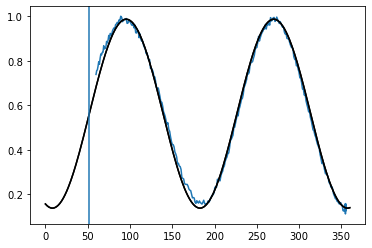

In [17]:
f = concattest.V[i[0]:i[1],900,0]/concattest.V[i[0]:i[1],900,0].max()

for i in [(10950,11400)]:
    plot(concattest.drone_yaw_interp[offset:][i[0]:i[1]], f)


popt, pcov = opt.curve_fit(sin_fun, concattest.drone_yaw_interp[offset:][i[0]:i[1]], f, p0=[1,2,1,1])
plot(np.linspace(0,360,360), sin_fun(np.linspace(0,360,360), *popt), 'k')

popt, pcov = opt.curve_fit(sin_fun2, concattest.drone_yaw_interp[offset:][i[0]:i[1]], f, p0=[1,2,1,1])
plot(np.linspace(0,360,360), sin_fun2(np.linspace(0,360,360), *popt), 'k')

# plot(np.linspace(0,360,360), 0.42434558*np.sin(2.06246157*np.linspace(0,360,360)*np.pi/180-107.03611896*np.pi/180)+0.56226741)

axvline(popt[2])
popt


In [18]:
popt, pcov = opt.curve_fit(sin_fun, concattest.drone_yaw_interp[offset:][i[0]:i[1]], \
                           1e7*(concattest.V[i[0]:i[1],900,0]), p0=[1,2,1,1])


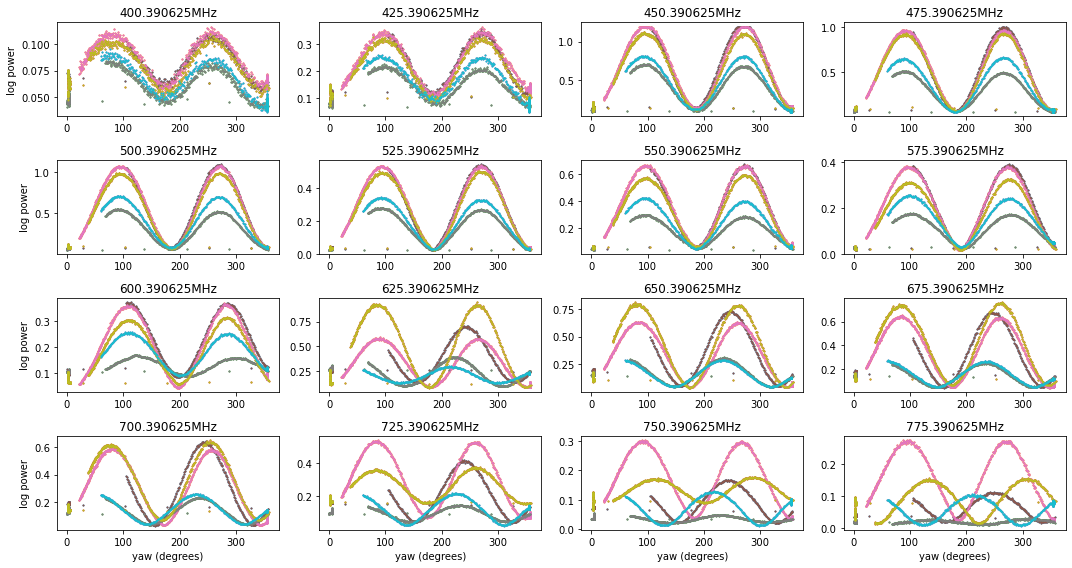

In [19]:
offset = 100
fig = figure(figsize = (15,8))
for i, freq in enumerate(np.arange(1023,0,-64)):
    freq1=freqs[freq]
    ax = fig.add_subplot(4,4,i+1)
    for j in np.arange(6,8,1):
        
        for k in [(7080, 7420),(8090,8700),(9150,9600),(10050,10550),(10950,11400)]:
            ax.plot(concattest.drone_yaw_interp[offset:][k[0]:k[1]], 
                    1e7*(concattest.V[k[0]:k[1],freq,0]), '.', markersize = 2)

        
#         ax.plot(test_concat.drone_yaw_interp[offset:][inds], 10*np.log10(test_concat.V[inds,freq,j])\
#                 -np.max(10*np.log10(test_concat.V[:,freq,j][inds])), '.', markersize = 2)
    ax.set_title(str(freq1)+'MHz')
    if i%4 == 0: ax.set_ylabel('log power')
    if i in range(12,16): ax.set_xlabel('yaw (degrees)')
#wtf
tight_layout()
show()

0 1


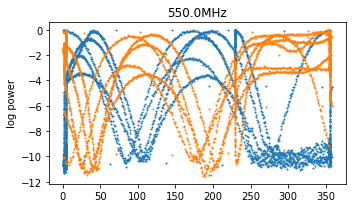

In [20]:
lb = 6600
ub = 11500
offset = 0

for chan in [(a,a+1) for a in np.arange(0,2,2)]:
    print(chan[0],chan[1])
    fig = figure(figsize = (5,3))
    for i, freq in enumerate([640]):
        freq1 = freqs[freq]
        ax = fig.add_subplot(1,1,i+1)
        for j in np.arange(chan[0],chan[1]+1,1):
            ax.plot(concattest.drone_yaw_interp[lb+offset:ub+offset], 
                    10*np.log10(concattest.V[:,freq,j][lb:ub])\
                    -np.max(10*np.log10(concattest.V[:,freq,j][lb:ub])), '.', markersize = 2)

    #         for k in [(7080, 7420),(8090,8700),(9150,9600),(10050,10550),(10950,11400)]:
    #             ax.plot(test_concat.drone_yaw_interp[offset:][k[0]:k[1]], 10*np.log10(test_concat.V[k[0]:k[1],freq,0])\
    #                     -np.max(10*np.log10(test_concat.V[:,freq,j][lb:ub])), '.', markersize = 2)

        ax.set_title(str(freq1)+'MHz')
        if i%4 == 0: ax.set_ylabel('log power')
        if i in range(12,16): ax.set_xlabel('yaw (degrees)')
    #wtf
#     suptitle(chan[0])
    tight_layout()
    show()

In [21]:
freqs[640]

550.0

0 1


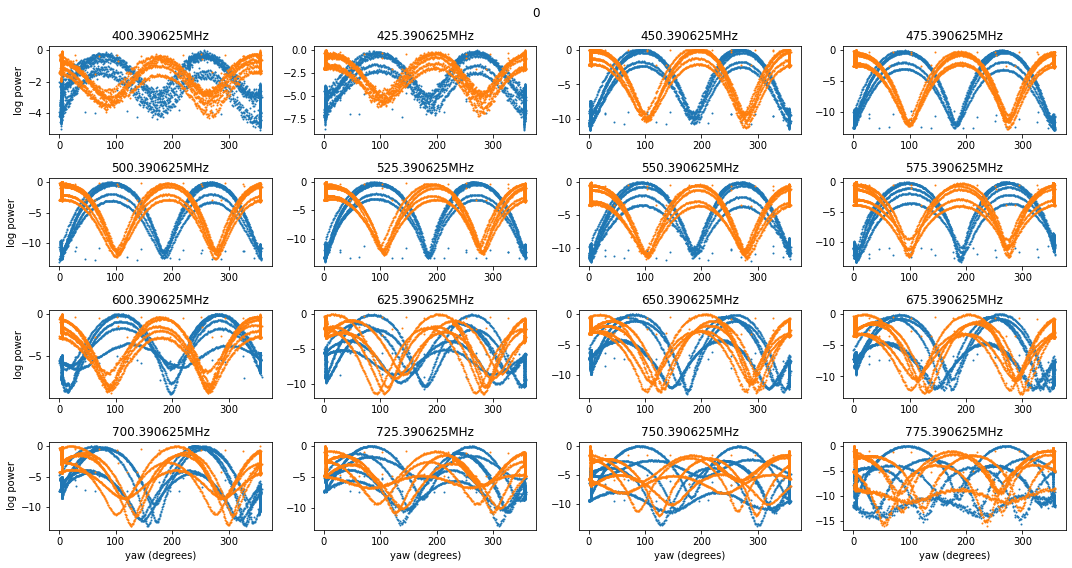

2 3


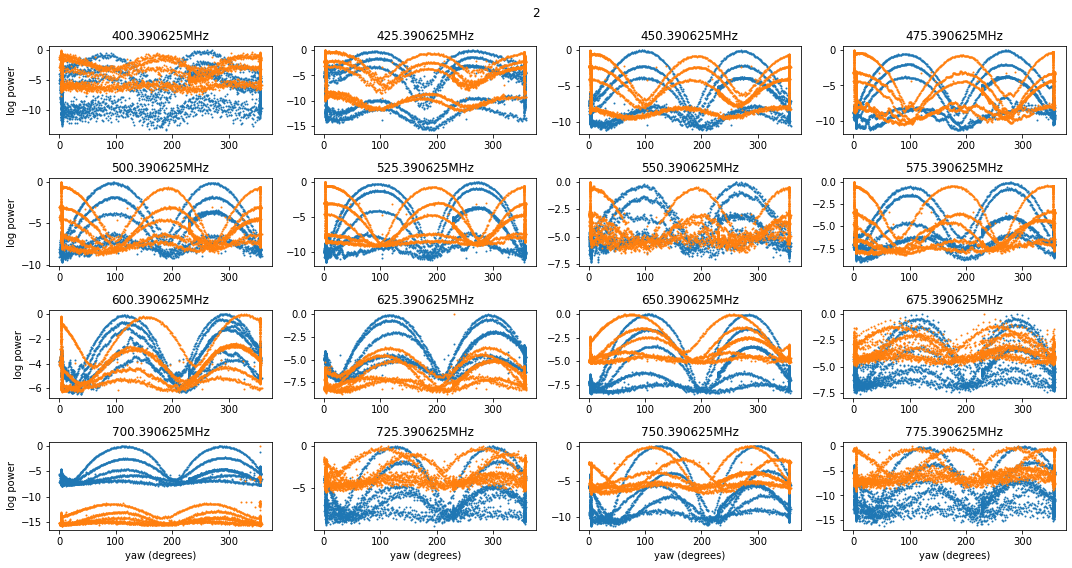

4 5


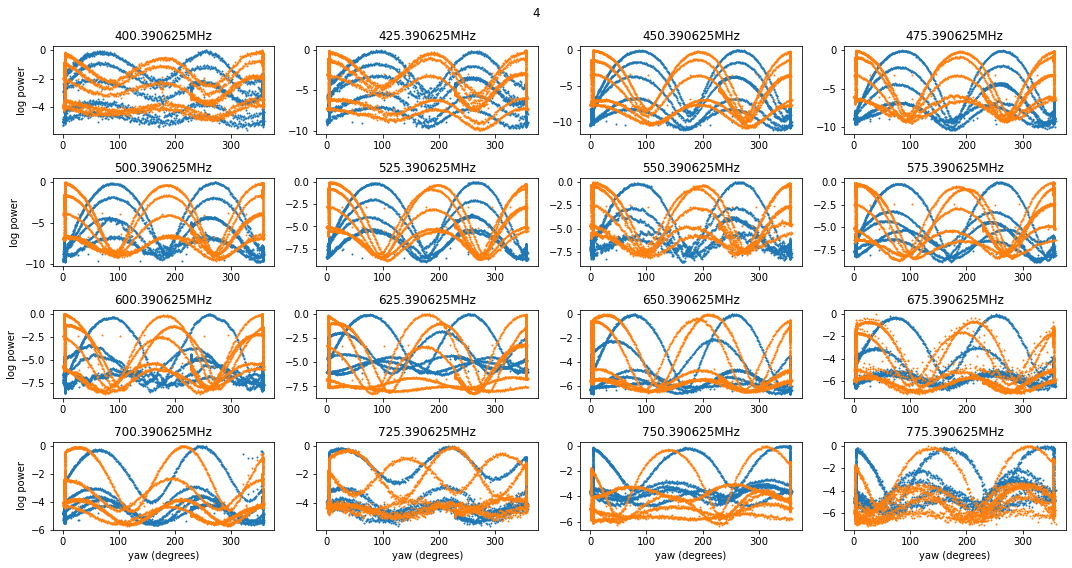

6 7


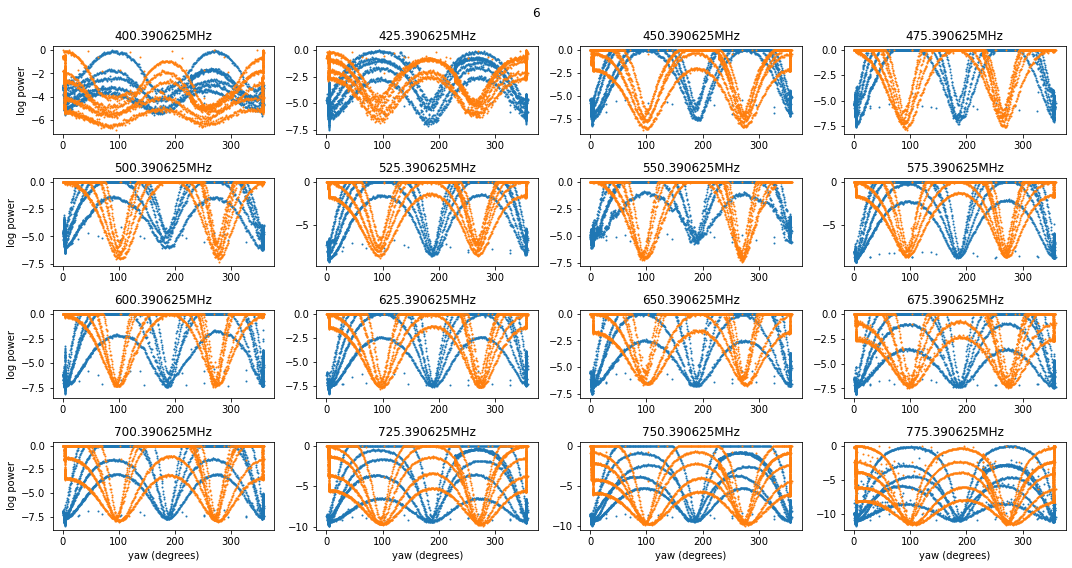

8 9


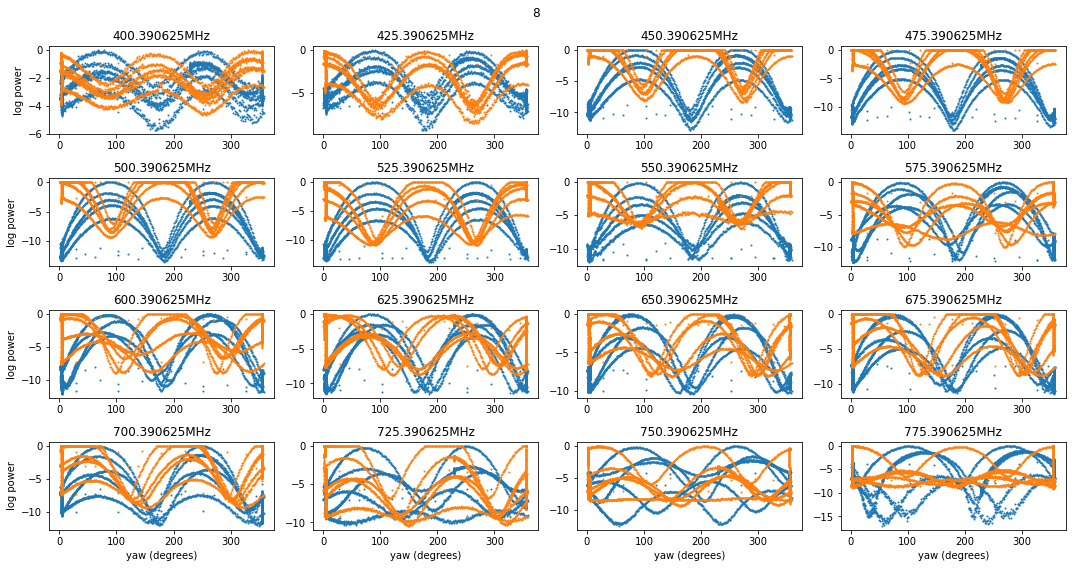

10 11


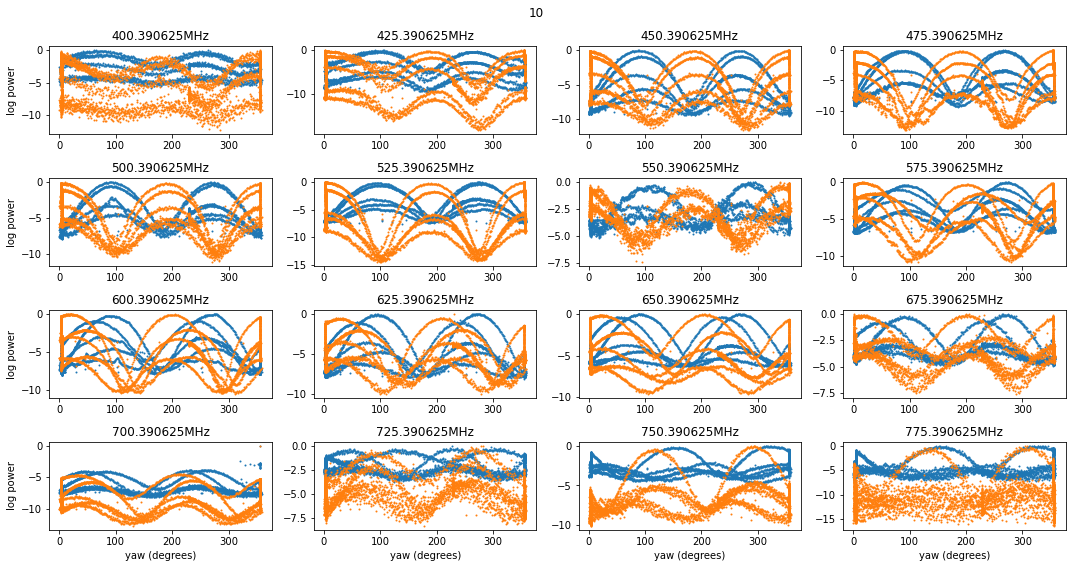

12 13


<ipython-input-24-e68fe52b6b82>:12: RuntimeWarning: divide by zero encountered in log10
  ax.plot(concattest.drone_yaw_interp[lb+offset:ub+offset], 10*np.log10(concattest.V[:,freq,j][lb:ub])\
<ipython-input-24-e68fe52b6b82>:13: RuntimeWarning: divide by zero encountered in log10
  -np.max(10*np.log10(concattest.V[:,freq,j][lb:ub])), '.', markersize = 2)
<ipython-input-24-e68fe52b6b82>:12: RuntimeWarning: invalid value encountered in subtract
  ax.plot(concattest.drone_yaw_interp[lb+offset:ub+offset], 10*np.log10(concattest.V[:,freq,j][lb:ub])\
<ipython-input-24-e68fe52b6b82>:12: RuntimeWarning: divide by zero encountered in log10
  ax.plot(concattest.drone_yaw_interp[lb+offset:ub+offset], 10*np.log10(concattest.V[:,freq,j][lb:ub])\
<ipython-input-24-e68fe52b6b82>:13: RuntimeWarning: divide by zero encountered in log10
  -np.max(10*np.log10(concattest.V[:,freq,j][lb:ub])), '.', markersize = 2)
<ipython-input-24-e68fe52b6b82>:12: RuntimeWarning: invalid value encountered in subtract
  ax

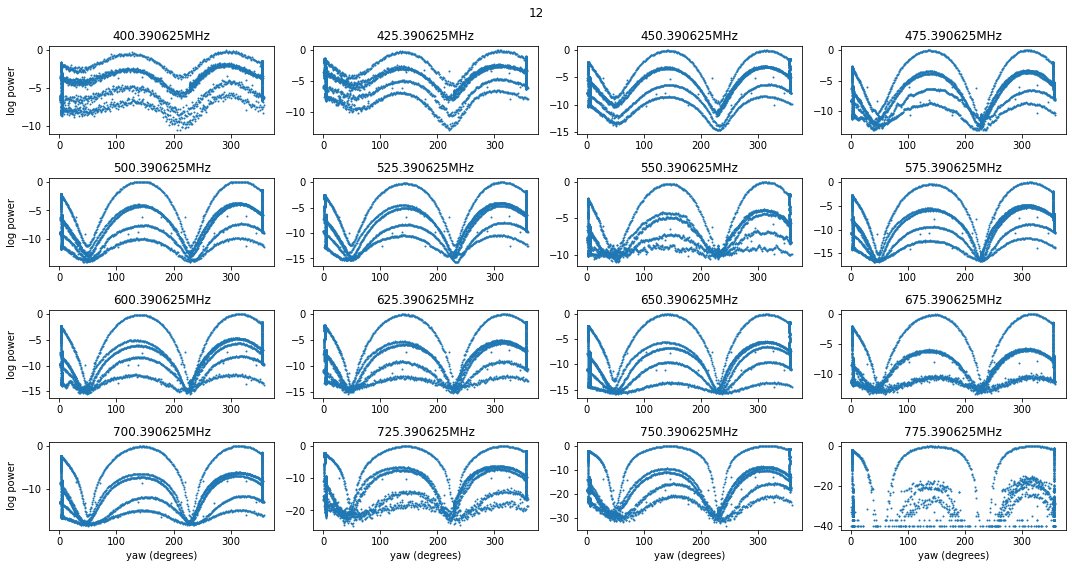

14 15


<ipython-input-24-e68fe52b6b82>:12: RuntimeWarning: divide by zero encountered in log10
  ax.plot(concattest.drone_yaw_interp[lb+offset:ub+offset], 10*np.log10(concattest.V[:,freq,j][lb:ub])\
<ipython-input-24-e68fe52b6b82>:13: RuntimeWarning: divide by zero encountered in log10
  -np.max(10*np.log10(concattest.V[:,freq,j][lb:ub])), '.', markersize = 2)
<ipython-input-24-e68fe52b6b82>:12: RuntimeWarning: divide by zero encountered in log10
  ax.plot(concattest.drone_yaw_interp[lb+offset:ub+offset], 10*np.log10(concattest.V[:,freq,j][lb:ub])\
<ipython-input-24-e68fe52b6b82>:13: RuntimeWarning: divide by zero encountered in log10
  -np.max(10*np.log10(concattest.V[:,freq,j][lb:ub])), '.', markersize = 2)
<ipython-input-24-e68fe52b6b82>:12: RuntimeWarning: divide by zero encountered in log10
  ax.plot(concattest.drone_yaw_interp[lb+offset:ub+offset], 10*np.log10(concattest.V[:,freq,j][lb:ub])\
<ipython-input-24-e68fe52b6b82>:13: RuntimeWarning: divide by zero encountered in log10
  -np.ma

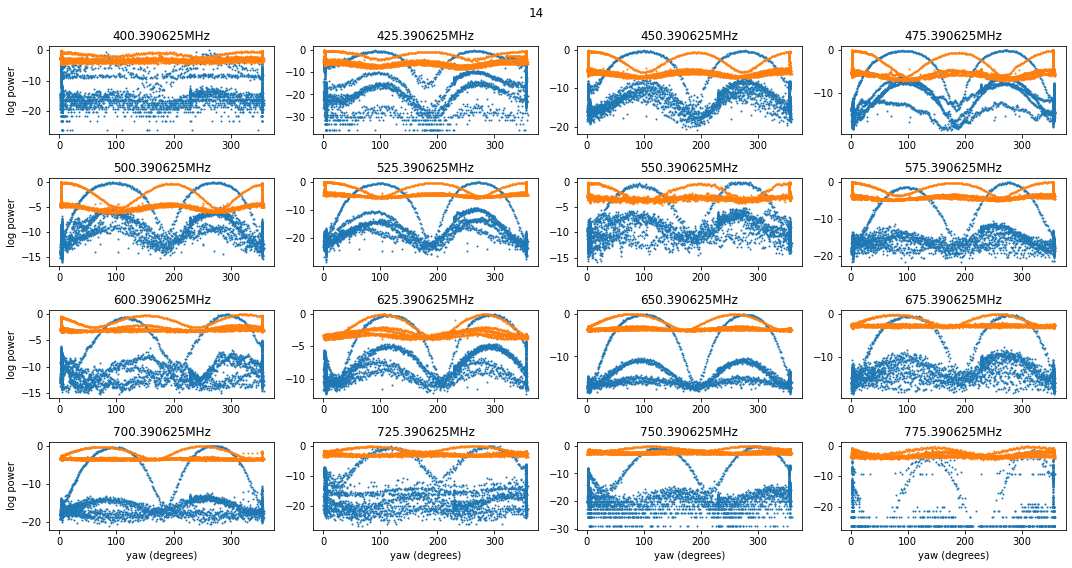

In [24]:
lb = 6600
ub = 11500
offset = 100

for chan in [(a,a+1) for a in np.arange(0,16,2)]:
    print(chan[0],chan[1])
    fig = figure(figsize = (15,8))
    for i, freq in enumerate(np.arange(1023,0,-64)):
        freq1=freqs[freq]
        ax = fig.add_subplot(4,4,i+1)
        for j in np.arange(chan[0],chan[1]+1,1):
            ax.plot(concattest.drone_yaw_interp[lb+offset:ub+offset], 10*np.log10(concattest.V[:,freq,j][lb:ub])\
                    -np.max(10*np.log10(concattest.V[:,freq,j][lb:ub])), '.', markersize = 2)

    #         for k in [(7080, 7420),(8090,8700),(9150,9600),(10050,10550),(10950,11400)]:
    #             ax.plot(test_concat.drone_yaw_interp[offset:][k[0]:k[1]], 10*np.log10(test_concat.V[k[0]:k[1],freq,0])\
    #                     -np.max(10*np.log10(test_concat.V[:,freq,j][lb:ub])), '.', markersize = 2)

        ax.set_title(str(freq1)+'MHz')
        if i%4 == 0: ax.set_ylabel('log power')
        if i in range(12,16): ax.set_xlabel('yaw (degrees)')
    #wtf
    suptitle(chan[0])
    tight_layout()
    show()

[-0.13250726  2.02430295 45.65375782  0.18133021]
[  0.1283217    2.01568975 -40.69205643   0.16744351]
[ 4.56847703e-02  2.03942943e+00 -2.13409300e+02  8.00963647e-02]
[ 0.02765704  2.30721234 -8.4885797   0.0545411 ]
[  0.43615312   2.04757866 -35.75426887   0.52076472]


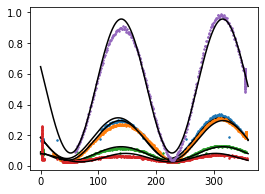

In [26]:
figure(figsize = (9,3))
subplot(1,2, 1)
offset = 100

for i in [(7080, 7420),(8090,8700),(9150,9600),(10050,10550),(10950,11400)]:
    plot(concattest.drone_yaw_interp[offset:][i[0]:i[1]], 1e7*(concattest.V[i[0]:i[1],600,12]), '.', markersize = 3)

    popt, pcov = opt.curve_fit(cos_fun, concattest.drone_yaw_interp[offset:][i[0]:i[1]], \
                           1e7*(concattest.V[i[0]:i[1],600,12]), p0=[1,2,1,1])
    
    plot(np.linspace(0,360,360), cos_fun(np.linspace(0,360,360), *popt), 'k')
#     axvline(popt[2])
    print(popt)
    
    


[-0.49177014  2.06746693  9.3464758   0.62895541]
[-0.49611878  2.02912948  6.9805115   0.64444448]
[-0.27308713  2.07749777 11.64292172  0.37087779]
[-0.43791681  2.03267991  6.93386338  0.57650617]
[-0.31990413  2.06250545  8.27057778  0.42387764]


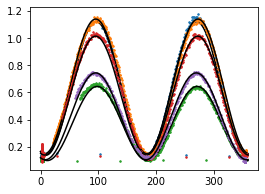

In [27]:
figure(figsize = (9,3))
subplot(1,2, 1)
offset = 100

for i in [(7080, 7420),(8090,8700),(9150,9600),(10050,10550),(10950,11400)]:
    plot(concattest.drone_yaw_interp[offset:][i[0]:i[1]], 1e7*(concattest.V[i[0]:i[1],900,0]), '.', markersize = 3)

    popt, pcov = opt.curve_fit(cos_fun, concattest.drone_yaw_interp[offset:][i[0]:i[1]], \
                           1e7*(concattest.V[i[0]:i[1],900,0]), p0=[1,2,1,1])
    
    plot(np.linspace(0,360,360), cos_fun(np.linspace(0,360,360), *popt), 'k')
#     axvline(popt[2])
    print(popt)

In [57]:
fits = np.zeros((5,4,1024))

for findex in range(1024):
    j = 0
    for i in [(7080, 7420),(8090,8700),(9150,9600),(10050,10550),(10950,11400)]:
        try:
            popt, pcov = opt.curve_fit(cos_fun, concattest.drone_yaw_interp[offset:][i[0]:i[1]], \
                               1e7*(concattest.V[i[0]:i[1],findex,0]), p0=[1,2,1,1])
            fits[findex,:,findex] = popt
        except:''
        j +=1

/home/ln267/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [58]:
fits_chime = np.zeros((2,5,8,1024))

for findex in range(1024):
    j = 0
    for i in [(7080, 7420),(8090,8700),(9150,9600),(10050,10550),(10950,11400)]:
        chan = 6
        try:
            popt, pcov = opt.curve_fit(cos_fun, concattest.drone_yaw_interp[offset:][i[0]:i[1]], \
                           1e7*(concattest.V[i[0]:i[1],findex,chan]), p0=[1,2,1,1])
            fits_chime[0,j,0:4,findex] = popt
            fits_chime[0,j,4:8,findex] = [pcov[i,i] for i in range(len(pcov))]
        except:''
        
        chan = 7
        try:
            popt, pcov = opt.curve_fit(cos_fun, concattest.drone_yaw_interp[offset:][i[0]:i[1]], \
                           1e7*(concattest.V[i[0]:i[1],findex,chan]), p0=[1,2,1,1])

            fits_chime[1,j,0:4,findex] = popt
            fits_chime[1,j,4:8,findex] = [pcov[i,i] for i in range(len(pcov))]
        except:''
            
        j +=1

In [59]:
fits_hirax = np.zeros((2,5,8,1024))

for findex in range(1024):
    j = 0
    for i in [(7080, 7420),(8090,8700),(9150,9600),(10050,10550),(10950,11400)]:
        chan = 0
        try:
            popt, pcov = opt.curve_fit(cos_fun, concattest.drone_yaw_interp[offset:][i[0]:i[1]], \
                               1e7*(concattest.V[i[0]:i[1],findex,chan]), p0=[1,2,1,1])
        
            fits_hirax[0,j,0:4,findex] = popt
            fits_hirax[0,j,4:8,findex] = [pcov[i,i] for i in range(len(pcov))]
        except:''
        chan = 1
        try:
            popt, pcov = opt.curve_fit(cos_fun, concattest.drone_yaw_interp[offset:][i[0]:i[1]], \
                        1e7*(concattest.V[i[0]:i[1],findex,chan]), p0=[1,2,1,1])
        
            fits_hirax[1,j,0:4,findex] = popt
            fits_hirax[1,j,4:8,findex] = [pcov[i,i] for i in range(len(pcov))]
        except:''
        j +=1

In [60]:
fits2 = np.zeros((5,8,1024))

for findex in range(1024):
    j = 0
    for i in [(7080, 7420),(8090,8700),(9150,9600),(10050,10550),(10950,11400)]:
        try:
            popt, pcov = opt.curve_fit(cos_fun, concattest.drone_yaw_interp[offset:][i[0]:i[1]], \
                               1e7*(concattest.V[i[0]:i[1],findex,0]), p0=[1,2,1,1])
#         residuals = (1e7*(test_concat.V[i[0]:i[1],findex,0])-cos_fun(test_concat.drone_yaw_interp[offset:][i[0]:i[1]], *popt))
        
            fits2[j,0:4,findex] = popt
            fits2[j,4:8,findex] = [pcov[i,i] for i in range(len(pcov))]
#         fits2[j,4,findex] = residuals_perc
        except:''
        j +=1

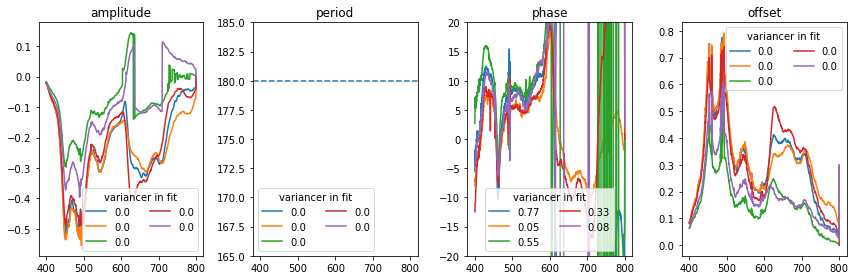

In [61]:

titles = ['amplitude', 'period', 'phase', 'offset']

figure(figsize = (12,4))
for j in range(4):
    subplot(1,4,j+1)
    for i in range(5):
        plot(np.linspace(800,400,1024), fits2[i,j,:], label = round(np.median(fits2[i,j+4,:]),2))
    title(titles[j])
    if j == 1: 
        ylim(165,185)
        axhline(180, linestyle = '--')
    if j == 2: ylim(-20,20)
    legend(title = 'variancer in fit', ncol = 2)
tight_layout()

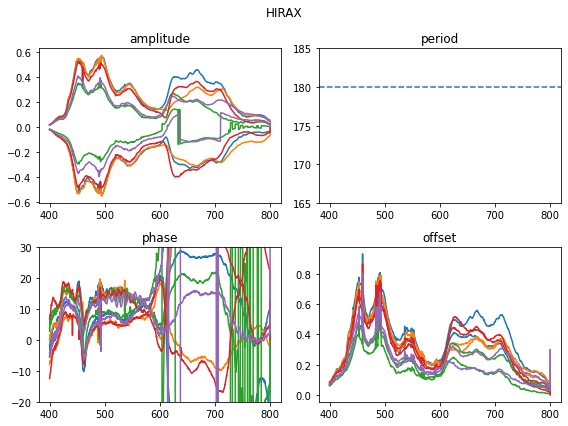

In [48]:
titles = ['amplitude', 'period', 'phase', 'offset']

figure(figsize = (8,6))
for j in range(4):
    subplot(2,2,j+1)
    col = ['C0', 'C1', 'C2','C3','C4']
    for i in range(5):
        plot(np.linspace(800,400,1024), fits_hirax[0,i,j,:], color = col[i])
        plot(np.linspace(800,400,1024), fits_hirax[1,i,j,:],  color = col[i])
    title(titles[j])
    if j == 1: 
        ylim(165,185)
        axhline(180, linestyle = '--')
    if j == 2: ylim(-20,30)
#     legend(title = 'variancer in fit', ncol = 2)

suptitle('HIRAX')
tight_layout()

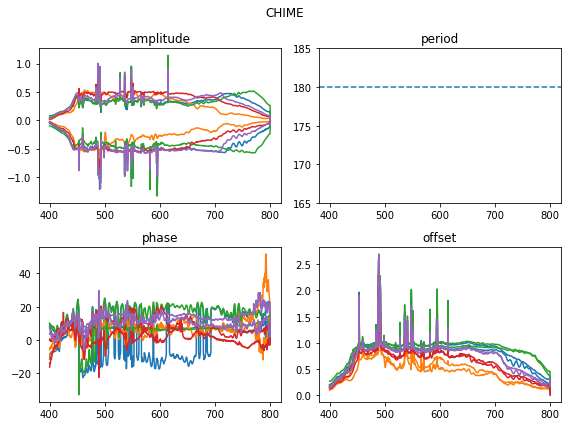

In [49]:
titles = ['amplitude', 'period', 'phase', 'offset']

figure(figsize = (8,6))
for j in range(4):
    subplot(2,2,j+1)
    col = ['C0', 'C1', 'C2','C3','C4']
    for i in range(5):
        plot(np.linspace(800,400,1024), fits_chime[0,i,j,:], color = col[i])
        plot(np.linspace(800,400,1024), fits_chime[1,i,j,:],  color = col[i])
    title(titles[j])
    if j == 1: 
        ylim(165,185)
        axhline(180, linestyle = '--')
#     if j == 2: ylim(-20,20)
#     legend(title = 'variancer in fit', ncol = 2)

suptitle('CHIME')
tight_layout()

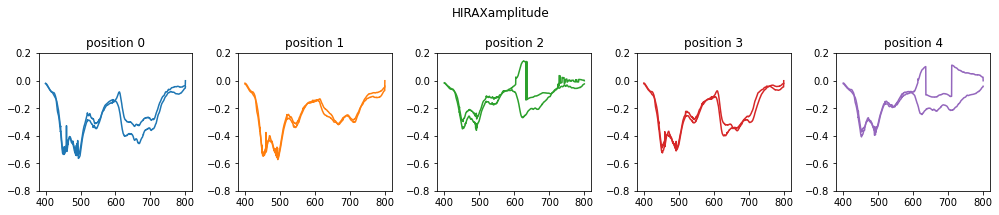

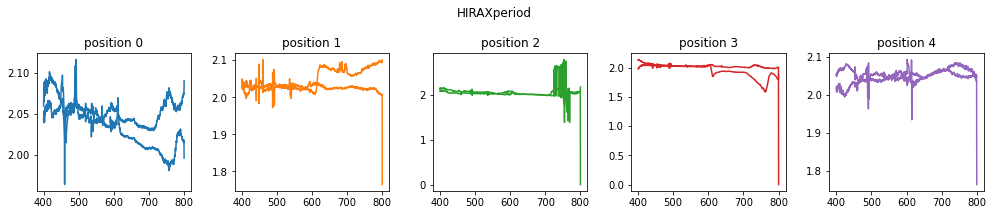

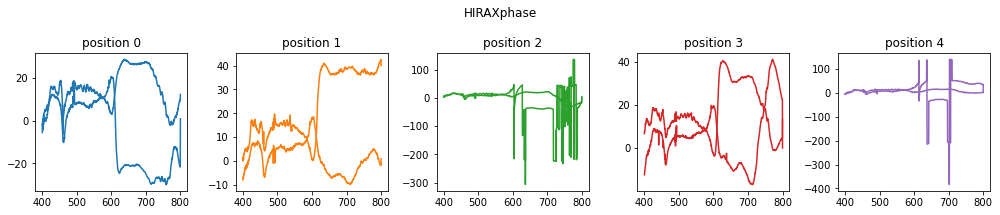

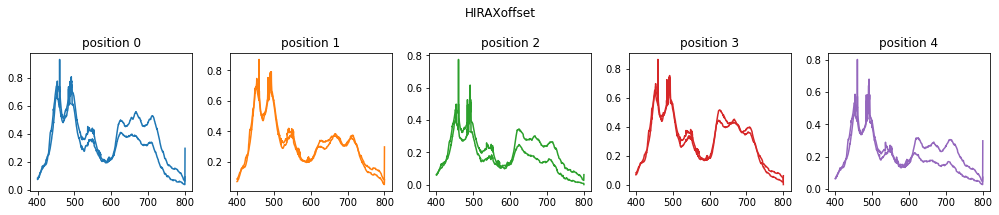

In [50]:
# plot amplitude for pol on each dish
# plot period ... 
for j in range(4):    
    figure(figsize = (14,3))
    col = ['C0', 'C1', 'C2','C3','C4']
    for i in range(5):
        subplot(1,5,i+1)
        plot(np.linspace(800,400,1024), fits_hirax[0,i,j,:], color = col[i])
        if j ==0: 
            plot(np.linspace(800,400,1024), -1*fits_hirax[1,i,j,:],  color = col[i])
            ylim(-0.8,0.2)
        else: 
            plot(np.linspace(800,400,1024), fits_hirax[1,i,j,:],  color = col[i])

        title('position '+str(i))
    suptitle('HIRAX'+ titles [j])
    tight_layout()
    show()

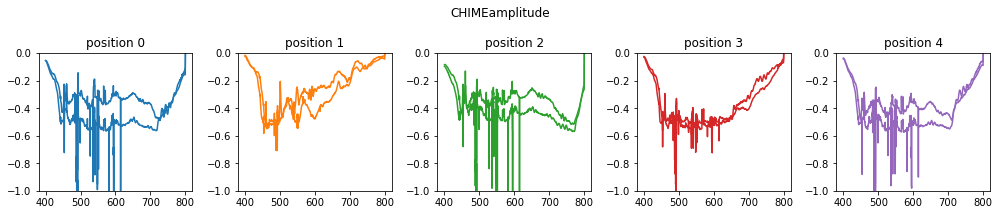

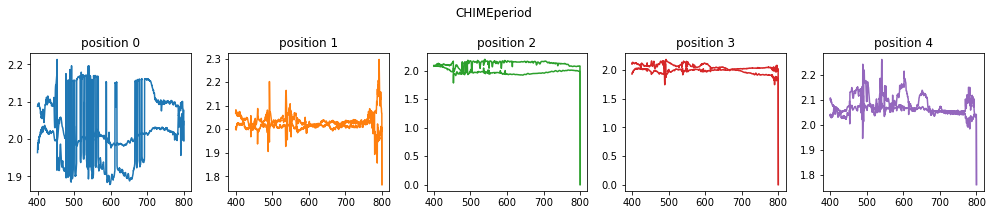

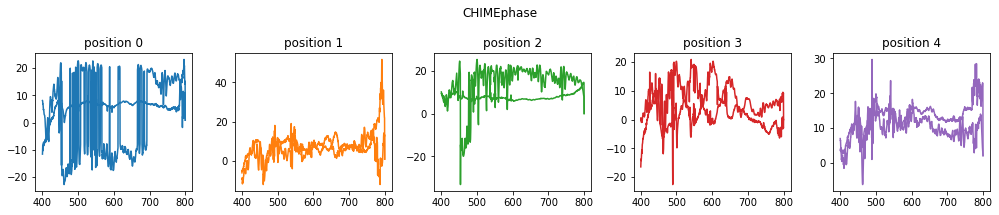

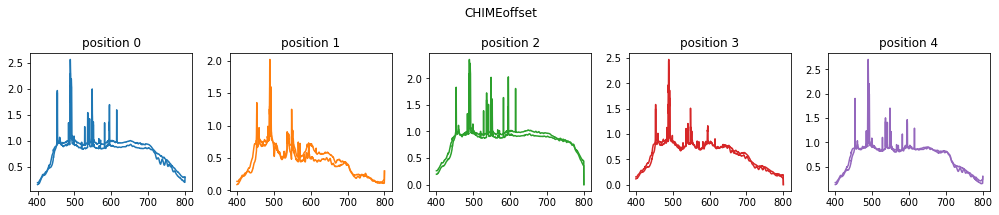

In [51]:
# plot amplitude for pol on each dish
# plot period ... 
for j in range(4):    
    figure(figsize = (14,3))
    col = ['C0', 'C1', 'C2','C3','C4']
    for i in range(5):
        subplot(1,5,i+1)
        plot(np.linspace(800,400,1024), fits_chime[0,i,j,:], color = col[i])
        if j ==0: 
            plot(np.linspace(800,400,1024), -1*fits_chime[1,i,j,:],  color = col[i])
            ylim(-1,0)
        else: 
            plot(np.linspace(800,400,1024), fits_chime[1,i,j,:],  color = col[i])

        title('position '+str(i))
    suptitle('CHIME'+ titles [j])
    tight_layout()
    show()

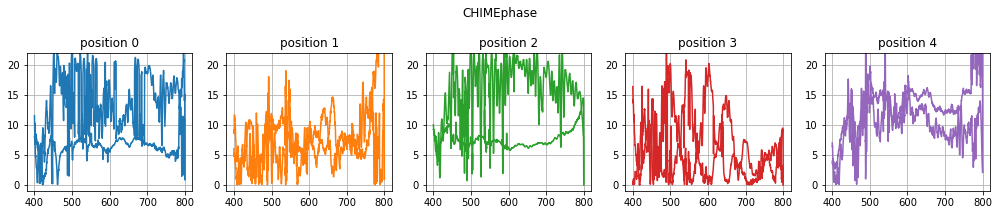

In [52]:
# plot phase for individual locations for both hirax and chime

figure(figsize = (14,3))
j=2
col = ['C0', 'C1', 'C2','C3','C4']
for i in range(5):
    subplot(1,5,i+1)
    plot(np.linspace(800,400,1024), np.abs(fits_chime[0,i,j,:]), color = col[i])
    plot(np.linspace(800,400,1024), np.abs(fits_chime[1,i,j,:]),  color = col[i])
    grid()
    title('position '+str(i))
    ylim(-1,22)
suptitle('CHIME'+ titles [j])
tight_layout()


In [55]:
# ????
#fits_hirax[:,:,1,:] = 360/fits_hirax[:,:,1,:]
#fits_chime[:,:,1,:] = 360/fits_chime[:,:,1,:]
#fits2[:,1,:] = 360/fits2[:,1,:]

<ipython-input-55-db24ed9bdd6b>:1: RuntimeWarning: divide by zero encountered in true_divide
  fits_hirax[:,:,1,:] = 360/fits_hirax[:,:,1,:]
<ipython-input-55-db24ed9bdd6b>:2: RuntimeWarning: divide by zero encountered in true_divide
  fits_chime[:,:,1,:] = 360/fits_chime[:,:,1,:]
<ipython-input-55-db24ed9bdd6b>:3: RuntimeWarning: divide by zero encountered in true_divide
  fits2[:,1,:] = 360/fits2[:,1,:]


In [54]:
print(fits_chime[:,:,1,:])

[[[1.99595738 2.04872325 2.04587678 ... 1.98979889 1.97782687 1.9639212 ]
  [1.76469926 2.00884796 1.9897705  ... 2.08257629 2.08201412 2.06829652]
  [0.         1.99001368 1.98974923 ... 2.0922287  2.09394681 2.09290693]
  [0.         1.99876426 2.02165531 ... 1.95410543 1.93762774 1.92884431]
  [1.7628327  2.02322529 2.02831424 ... 2.1052564  2.10757034 2.09944355]]

 [[1.99595738 2.07781097 2.07765984 ... 2.08776844 2.08848148 2.08805668]
  [1.76469926 2.06787091 2.0684415  ... 2.01102551 2.00541063 2.00190333]
  [0.         2.0829179  2.08457738 ... 2.08006241 2.08281332 2.08134061]
  [0.         1.84748926 1.84460755 ... 2.11331028 2.12285219 2.10340262]
  [1.7628327  2.04191815 2.04064216 ... 2.04292199 2.03495236 2.03879389]]]


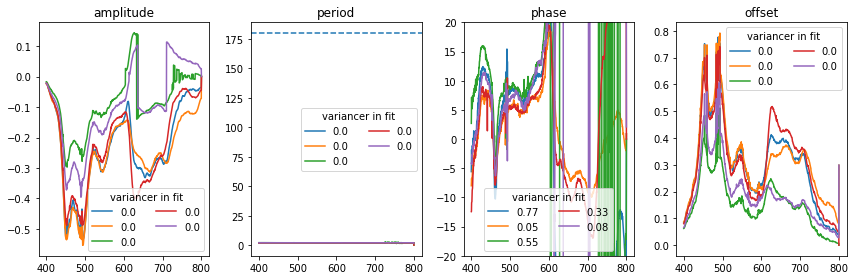

In [63]:
titles = ['amplitude', 'period', 'phase', 'offset']
figure(figsize = (12,4))
for j in range(4):
    subplot(1,4,j+1)
    for i in range(5):
        plot(np.linspace(800,400,1024), fits2[i,j,:], label = round(np.median(fits2[i,j+4,:]),2))
    title(titles[j])
    if j == 1: 
        #ylim(165,185)
        axhline(180, linestyle = '--')
    if j == 2: ylim(-20,20)
    legend(title = 'variancer in fit', ncol = 2)
tight_layout()


In [64]:
fits_all = np.zeros((16,5,8,1024))

for findex in range(1024):
    j = 0
    for i in [(7080, 7420),(8090,8700),(9150,9600),(10050,10550),(10950,11400)]:
        
        for chan in np.arange(0,16,1):
            try:
                popt, pcov = opt.curve_fit(cos_fun, test_concat.drone_yaw_interp[offset:][i[0]:i[1]], \
                                   1e7*(test_concat.V[i[0]:i[1],findex,chan]), p0=[1,2,1,1])

                fits_all[chan,j,0:4,findex] = popt
                fits_all[chan,j,4:8,findex] = [pcov[i,i] for i in range(len(pcov))]
            except: pass
    
        j +=1